# Single Instances from Bayrak & Bailey (2008)
In this Notebook we look into single instances of grid-networks similar to Bayrak & Bailey (2008). Note the difference, that we only work with grids that have horizontal and vertical edges, no diagonal edges. We compare the true costs (objectives) and visualizations of the shortest paths when the interdictor uses bender's decomposition (assuming full evader knowledge) and a bi-level program for solving an asymmetric shortest path network interdiction formulation (assuming faulty evader knowledge).

In [57]:
# Add the parent directory to the path
import sys, os
sys.path.insert(0, os.path.abspath("../.."))

## Problem Setup
We first import all relevant software libraries and define the shortest path network interdiction problem.

In [58]:
import numpy as np
import matplotlib.pyplot as plt

from solvers.spnia_asym import AsymmetricSPNI
from models.ShortestPathGrb import shortestPathGrb
from models.ShortestPathGrid import ShortestPathGrid
from solvers.BendersDecomposition import BendersDecomposition

In [ ]:
# Hyperparameters
c_min: float = 1.0
c_max: float = 10.0
d_min: float = 1.0
d_max: float = 10.0
Q = 0.6
B = 5
network = (6, 8)
np.random.seed(31)

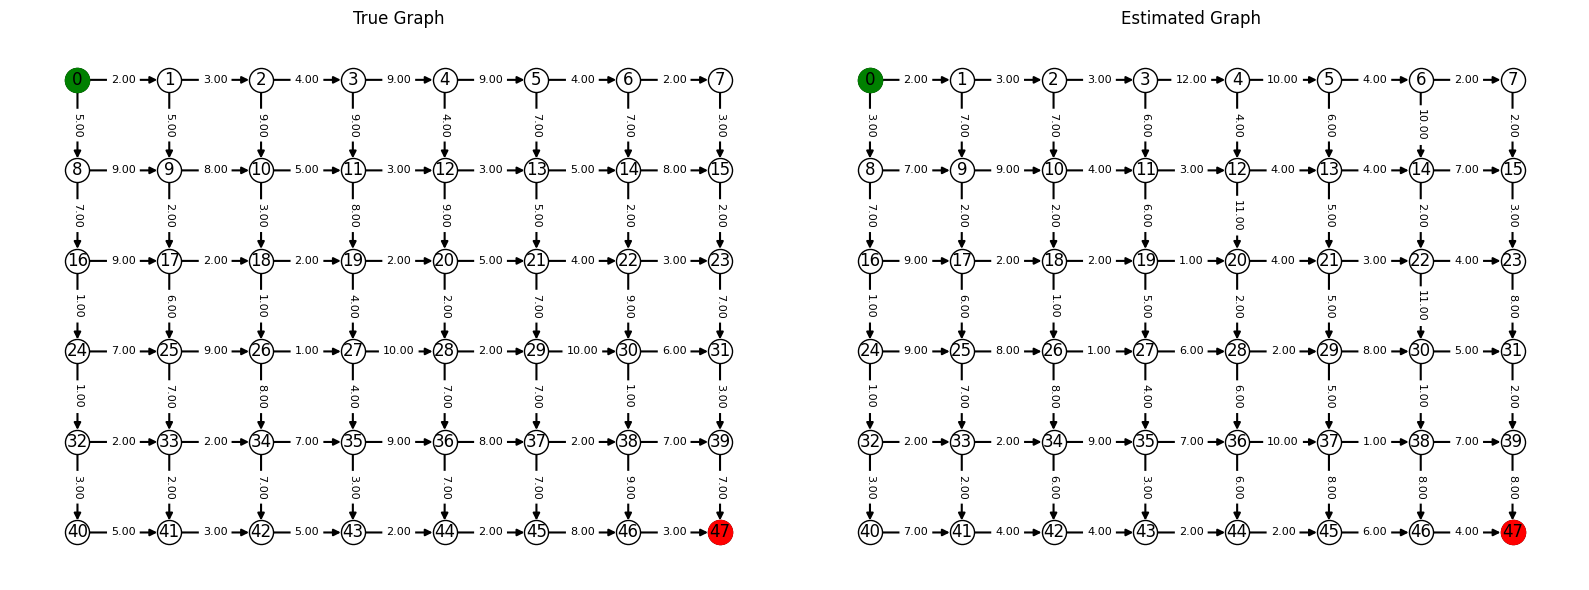

In [69]:
# Generate true and estimated costs and delays with the formula from Bayrak & Bailey (2008)
true_costs = (np.random.rand(network[0] * (network[1] - 1) + (network[0] - 1) * network[1]) * (c_max - c_min) + c_min).round(0)
true_delays = (np.random.rand(network[0] * (network[1] - 1) + (network[0] - 1) * network[1]) * (d_max - d_min) + d_min).round(0)
est_costs = (np.random.rand(network[0] * (network[1] - 1) + (network[0] - 1) * network[1]) * 2 * (1 - Q) * true_costs + Q * true_costs).round(0)
est_delays = (np.random.rand(network[0] * (network[1] - 1) + (network[0] - 1) * network[1]) * 2 * (1 - Q) * true_delays + Q * true_delays).round(0)

# Create the true and estimated graphs
true_graph = ShortestPathGrid(network[0], network[1], true_costs)
est_graph = ShortestPathGrid(network[0], network[1], est_costs)

# Visualize the the graphs with true and estimated costs
fig, ax = plt.subplots(1,2,figsize=(16, 6))
true_graph.visualize(ax=ax[0], title="True Graph")
est_graph.visualize(ax=ax[1], title="Estimated Graph")
fig.tight_layout()

## Naive Interdictor
First, the interdictor assumes that the evader has the same knowledge of the network parameters. The optimization problem is solved with Bender's Algorithm.

In [61]:
# Solutions without information asymmetry
interdictor_I = BendersDecomposition(shortestPathGrb(true_graph), k=B, interdiction_cost=true_delays, max_cnt=20, eps=.1)
x_true_I, y_true_I, obj_true_I = interdictor_I.solve()

# Estimated shortest path after symmetric interdiction
est_shortest_path = shortestPathGrb(est_graph)
est_shortest_path.setObj(est_costs + x_true_I * est_delays)
y_est_I, obj_est_I = est_shortest_path.solve()

Bender's decomposition running:
-------------------------------
Iteration 1: z_max = 83.0, z_min = 41.0
Iteration 2: z_max = 65.0, z_min = 48.0
Iteration 3: z_max = 63.0, z_min = 48.0
Iteration 4: z_max = 63.0, z_min = 54.0
Iteration 5: z_max = 62.0, z_min = 54.0
Iteration 6: z_max = 62.0, z_min = 55.0
Iteration 7: z_max = 61.0, z_min = 53.0
Iteration 8: z_max = 60.0, z_min = 59.0
Iteration 9: z_max = 60.0, z_min = 59.0
Iteration 10: z_max = 60.0, z_min = 60.0
-------------------------------
Found epsilon-optimal solution after 10 iterations with epsilon = 0.00


Objective (True shortest path): 	60.0
Objective (Estimated shortest path): 	61.0


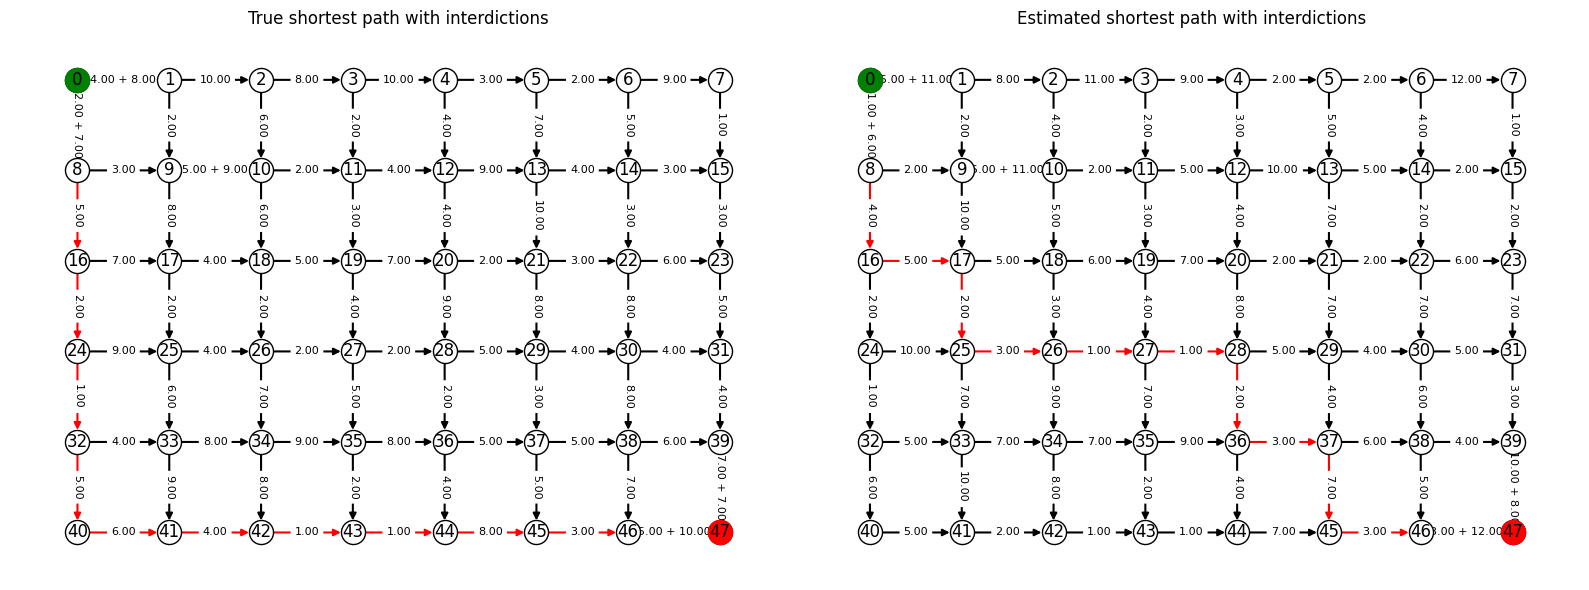

In [62]:
# Print results
print(f"Objective (True shortest path): \t{obj_true_I}")
print(f"Objective (Estimated shortest path): \t{true_graph(y_est_I, interdictions=x_true_I*true_delays)}")

# Visualize results
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
true_graph.visualize(ax=ax[0], 
                     colored_edges=y_true_I, 
                     dashed_edges=x_true_I, 
                     interdictions=x_true_I*true_delays, 
                     title="True shortest path with interdictions")
est_graph.visualize(ax=ax[1], 
                   colored_edges=y_est_I, 
                   dashed_edges=x_true_I, 
                   interdictions=x_true_I*est_delays, 
                   title="Estimated shortest path with interdictions")
fig.tight_layout()

## Knowledgeable Interdictor
Now, the interdictor has full knowledge of the evader's estimates of the graph parameters. 

In [ ]:
# Solution for interdictor with asymmetric information
asym_interdictor = AsymmetricSPNI(true_graph, budget=B, true_costs=true_costs, true_delays=true_delays, est_costs=est_costs, est_delays=est_delays, lsd=1)
x_true_II, obj_true_II = asym_interdictor.solve()

# True shortest path after symmetric interdiction
true_shortest_path = shortestPathGrb(true_graph)
true_shortest_path.setObj(true_costs + x_true_II * true_delays)
y_true_II, obj_true_II = true_shortest_path.solve()

# Estimated shortest path after symmetric interdiction
est_shortest_path = shortestPathGrb(est_graph)
est_shortest_path.setObj(est_costs + x_true_II * est_delays)
y_est_II, obj_est_II = est_shortest_path.solve()


Objective (True shortest path): 	59.0
Objective (Estimated shortest path): 	65.0


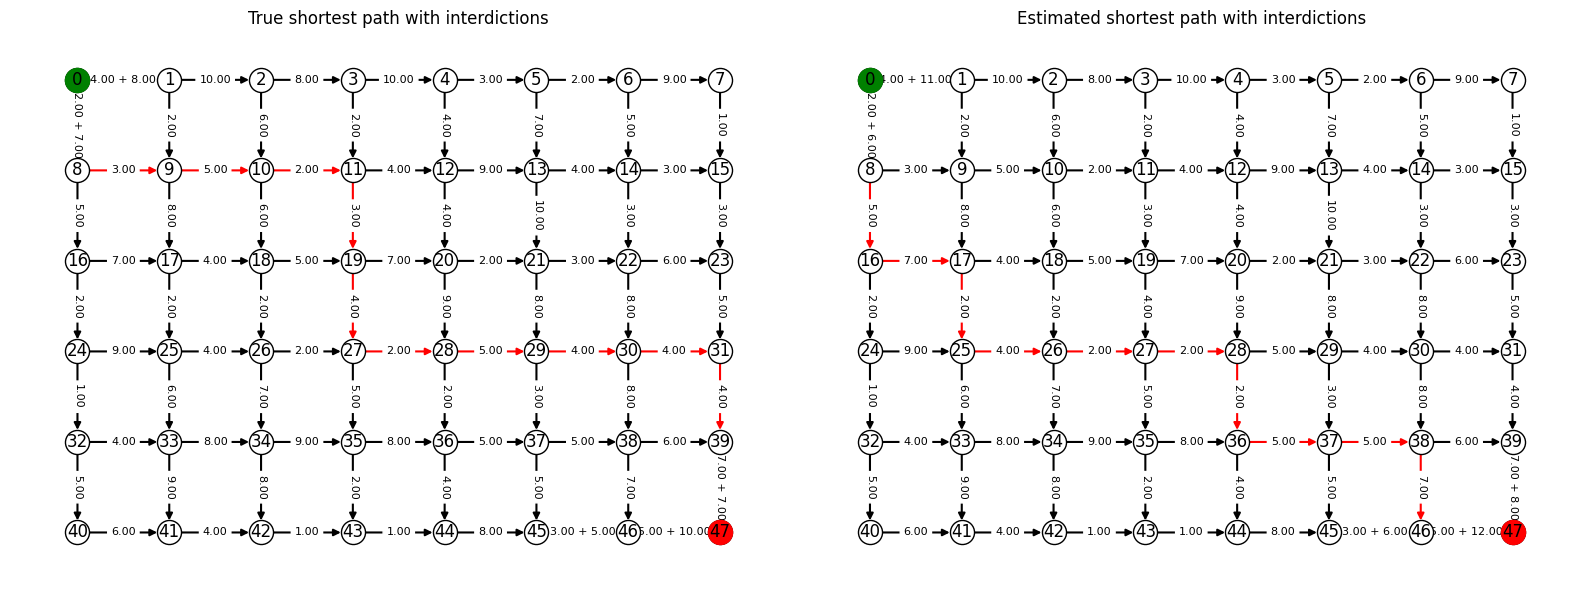

In [64]:
# Print results
print(f"Objective (True shortest path): \t{obj_true_II}")
print(f"Objective (Estimated shortest path): \t{true_graph(y_est_II, interdictions=x_true_II*true_delays)}")

# Visualize results
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
true_graph.visualize(ax=ax[0], 
                     colored_edges=y_true_II, 
                     dashed_edges=x_true_II, 
                     interdictions=x_true_II*true_delays, 
                     title="True shortest path with interdictions")
true_graph.visualize(ax=ax[1], 
                   colored_edges=y_est_II, 
                   dashed_edges=x_true_II, 
                   interdictions=x_true_II*est_delays, 
                   title="Estimated shortest path with interdictions")
fig.tight_layout()